## ECE 239 Final Project

In this project we explore various deep learning algorithms on the EEG dataset. 


In [1]:
# Imports and setup

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from keras.layers import GRU
import matplotlib.pyplot as plt

from utils.load_data import *
from utils.utilities import *
from models.cnn import CNN
from models.rnn import RNN
from models.autoencoder import Autoencoder


%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Loads data from the EEG dataset and removes all EOG data

person_train_val, X_train_val, y_train_val, person_test, X_test, y_test = load_EEG_data()

print ('Training/Valid data shape: {}'.format(X_train_val.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_val.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_val.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Split into train and validation datasets

In [3]:
X_train, y_train, X_val, y_val = split_train_val(X_train_val, y_train_val, percent_validation=0.1)

print ('Training data shape: {}'.format(X_train.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Validation data shape: {}'.format(X_val.shape))
print ('Validation target shape: {}'.format(y_val.shape))

Training data shape: (1904, 22, 1000)
Training target shape: (1904,)
Validation data shape: (211, 22, 1000)
Validation target shape: (211,)


## One hot encoding for all labels

In [4]:
print (y_val[33])
print (y_val.shape)
print (y_test.shape)

y_train_labels = one_hot_encode(y_train)
y_val_labels = one_hot_encode(y_val)
y_test_labels = one_hot_encode(y_test)

print (y_val_labels[33])
print (y_val_labels.shape)
print (y_test_labels.shape)


771
(211,)
(443,)
[0. 0. 1. 0.]
(211, 4)
(443, 4)


## Classifying data using a CNN

In [5]:
cnn = CNN(X_train, y_train_labels, X_val, y_val_labels, X_test, y_test_labels)
cnn.train(stride=2, optimizer='adam', epochs=5)
test_loss, test_accuracy = cnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Instructions for updating:
Colocations handled automatically by placer.
Train on 1904 samples, validate on 211 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1904/1904 [==============================] - 1s 496us/sample - loss: 1.4269 - acc: 0.2773 - val_loss: 1.4025 - val_acc: 0.3081
Epoch 2/5
1904/1904 [==============================] - 1s 275us/sample - loss: 1.3654 - acc: 0.3120 - val_loss: 1.4398 - val_acc: 0.2986
Epoch 3/5
1904/1904 [==============================] - 1s 277us/sample - loss: 1.3483 - acc: 0.3419 - val_loss: 1.3986 - val_acc: 0.2844
Epoch 4/5
1904/1904 [==============================] - 1s 281us/sample - loss: 1.2981 - acc: 0.3792 - val_loss: 1.3908 - val_acc: 0.3412
Epoch 5/5
443/443 [==============================] - 0s 142us/sample - loss: 1.4326 - acc: 0.2799
Test loss: 1.4325961619951924
Test accuracy: 0.2799097


## Classifying data using an LSTM Architecture

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 5s 2ms/step - loss: 1.4223 - acc: 0.2558 - val_loss: 1.4032 - val_acc: 0.2938
Epoch 2/5
1904/1904 [==============================] - 4s 2ms/step - loss: 1.1920 - acc: 0.5646 - val_loss: 1.4024 - val_acc: 0.2607
Epoch 3/5
1904/1904 [==============================] - 4s 2ms/step - loss: 1.0206 - acc: 0.7190 - val_loss: 1.4199 - val_acc: 0.2796
Epoch 4/5
1904/1904 [==============================] - 4s 2ms/step - loss: 0.8731 - acc: 0.7642 - val_loss: 1.4285 - val_acc: 0.3128
Epoch 5/5
1904/1904 [==============================] - 3s 2ms/step - loss: 0.7397 - acc: 0.8277 - val_loss: 1.4892 - val_acc: 0.3081
Test loss: 1.478394570522868
Test accuracy: 0.32279909868003553


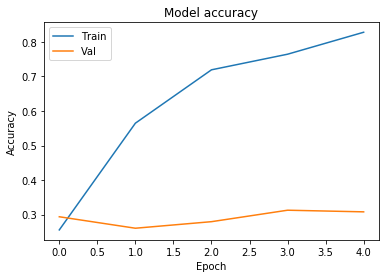

In [6]:
rnn = RNN(X_train, y_train_labels, X_val, y_val_labels, X_test, y_test_labels)
rnn.train(RNN_architecture=LSTM, activation="sigmoid", \
              optimizer='adam', epochs=5, batch_size=64, dropout=0.3)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


rnn.plot()

## Check Results

In [7]:
# TRAINING
print("TRAINING")
N = 400
sampleX = X_train[0:N,:,:]
sampleY = y_train_labels[0:N]
predictedY = rnn.predict(sampleX)
predictedLabels = np.argmax(predictedY, axis=1)
sampleLabels = np.argmax(sampleY, axis=1)

print("Predicted labels:")
print(predictedLabels)
print("Actual labels:")
print(sampleLabels)

num_equal = np.sum(1.0*np.equal(sampleLabels, predictedLabels))
print("Number of labels that are equal:")
print(num_equal)
print("Accuracy: ")
print(num_equal/N)

# VALIDATION
print("VALIDATION")
N = 400
sampleX = X_val[0:N,:,:]
sampleY = y_val_labels[0:N]
predictedY = rnn.predict(sampleX)
predictedLabels = np.argmax(predictedY, axis=1)
sampleLabels = np.argmax(sampleY, axis=1)

print("Predicted labels:")
print(predictedLabels)
print("Actual labels:")
print(sampleLabels)

num_equal = np.sum(1.0*np.equal(sampleLabels, predictedLabels))
print("Number of labels that are equal:")
print(num_equal)
print("Accuracy: ")
print(num_equal/N)



TRAINING
Predicted labels:
[3 1 1 1 3 1 2 0 2 1 1 0 1 3 1 3 2 0 0 0 2 2 2 0 2 2 3 1 3 1 3 3 3 3 3 3 3
 0 2 1 1 0 1 0 1 3 3 0 1 3 0 3 1 3 0 1 2 3 3 2 3 0 0 3 0 3 3 0 3 2 1 3 0 0
 1 0 1 3 3 0 2 2 0 3 1 3 3 3 0 3 3 2 2 2 3 3 3 2 3 2 2 2 2 2 2 0 3 1 0 1 2
 2 1 1 3 1 2 3 3 2 1 1 1 0 2 3 3 3 1 2 3 1 0 3 0 1 0 0 3 0 2 3 1 0 1 0 0 2
 0 1 1 3 2 2 0 3 0 1 2 1 3 2 0 3 0 2 2 3 0 1 2 2 3 0 1 0 0 1 2 0 2 0 3 2 2
 2 0 3 3 0 0 2 3 0 2 1 0 2 1 3 1 2 0 2 3 2 0 2 1 1 1 0 2 1 3 1 3 1 2 1 3 2
 2 2 1 2 0 2 3 2 2 1 0 1 3 0 3 3 0 2 3 3 2 1 0 3 3 3 2 3 2 2 3 1 3 1 2 2 3
 1 0 0 2 0 3 0 0 1 0 2 0 1 3 1 3 1 2 1 3 3 3 2 1 0 0 1 3 2 2 1 0 0 0 0 1 2
 3 1 3 1 3 2 3 0 2 2 3 0 1 0 3 1 2 0 1 1 2 1 1 3 3 3 1 1 0 0 0 0 0 2 0 0 2
 1 3 0 1 3 3 2 3 2 2 0 1 1 1 0 1 3 2 0 0 0 0 1 0 3 2 2 0 2 3 1 0 3 3 0 1 0
 2 2 3 3 1 1 3 1 0 1 1 2 1 3 1 2 1 0 2 3 0 1 1 2 2 0 0 2 0 3]
Actual labels:
[3 1 0 1 3 1 2 0 2 1 1 0 1 3 1 3 2 0 0 0 2 2 2 0 2 2 3 1 3 1 3 3 0 3 3 3 3
 0 2 1 1 0 1 0 1 3 3 0 1 3 0 3 1 3 0 1 2 3 3 2 3 0 0 3 0 3 3 0 3 2 1 3 

## Classifying Data using a GRU Architecture

In [8]:
rnn = RNN(X_train, y_train_labels, X_val, y_val_labels, X_test, y_test_labels)
rnn.train(RNN_architecture=GRU, activation="sigmoid", \
              optimizer='adam', epochs=5, batch_size=64, dropout=0.1)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 4s 2ms/step - loss: 1.4226 - acc: 0.2973 - val_loss: 1.3850 - val_acc: 0.2938
Epoch 2/5
1904/1904 [==============================] - 3s 1ms/step - loss: 1.1230 - acc: 0.5572 - val_loss: 1.4535 - val_acc: 0.2796
Epoch 3/5
1904/1904 [==============================] - 3s 2ms/step - loss: 0.8849 - acc: 0.6665 - val_loss: 1.4832 - val_acc: 0.3507
Epoch 4/5
1904/1904 [==============================] - 3s 1ms/step - loss: 0.6635 - acc: 0.8036 - val_loss: 1.5578 - val_acc: 0.3839
Epoch 5/5
1904/1904 [==============================] - 3s 1ms/step - loss: 0.4743 - acc: 0.8813 - val_loss: 1.5822 - val_acc: 0.3649
Test loss: 1.6185275849047418
Test accuracy: 0.336343114384141


In [9]:
person1_X_train, person1_y_train = extract_person_data(X_train_val, y_train_val, person_train_val, person=1)
person2_X_test, person2_y_test = extract_person_data(X_train_val, y_train_val, person_train_val, person=2)

In [10]:
rnn = RNN(person1_X_train, one_hot_encode(person1_y_train), None, None, person2_X_test, one_hot_encode(person2_y_test))
rnn.train(RNN_architecture=LSTM, activation="sigmoid", \
              optimizer='adam', epochs=5, batch_size=10, dropout=0.3)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/5
236/236 [==============================] - 3s 11ms/step - loss: 1.4474 - acc: 0.2373
Epoch 2/5
236/236 [==============================] - 1s 6ms/step - loss: 0.9805 - acc: 0.8008
Epoch 3/5
236/236 [==============================] - 1s 5ms/step - loss: 0.7643 - acc: 0.9195
Epoch 4/5
236/236 [==============================] - 1s 5ms/step - loss: 0.5826 - acc: 0.9661
Epoch 5/5
236/236 [==============================] - 1s 6ms/step - loss: 0.4142 - acc: 0.9958
Test loss: 1.4540871119095107
Test accuracy: 0.2923728816084943


## Autoencoder

In [90]:

autoencoder = Autoencoder(X_train, X_val, X_test)
autoencoder.train()
new_data = autoencoder.predict(X_train).reshape(X_train.shape)



Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 21s 11ms/sample - loss: -57405.0916 - acc: 5.2521e-04 - val_loss: -94936.6210 - val_acc: 0.0000e+00
Epoch 2/5
1904/1904 [==============================] - 16s 8ms/sample - loss: -135210.7690 - acc: 0.0000e+00 - val_loss: -132438.8789 - val_acc: 0.0000e+00
Epoch 3/5
1904/1904 [==============================] - 15s 8ms/sample - loss: -170645.6716 - acc: 5.2521e-04 - val_loss: -151157.5411 - val_acc: 0.0000e+00
Epoch 4/5
1904/1904 [==============================] - 15s 8ms/sample - loss: -190631.7945 - acc: 5.2521e-04 - val_loss: -162550.6210 - val_acc: 0.0000e+00
Epoch 5/5
1904/1904 [==============================] - 15s 8ms/sample - loss: -204367.9966 - acc: 5.2521e-04 - val_loss: -170880.3769 - val_acc: 0.0000e+00


In [91]:
abs_err = np.abs(X_train - new_data)
print("Absolute Error in encoded data is roughly: " + str(np.mean(abs_err)))
print(X_train[0,0,0:50])
print(X_train_restored[0,0,0:50])


Absolute Error in encoded data is roughly: 8.167755900244913
[ 19.7265625    9.765625     8.93554688  11.27929688   3.7109375
   5.12695312  -0.5859375   -3.56445312  -4.15039062  -6.29882812
  -4.4921875    1.46484375   1.51367188   3.17382812  11.27929688
  10.79101562   9.71679688   2.9296875    3.95507812   6.0546875
   5.12695312  12.40234375  13.33007812  16.74804688  12.3046875
  10.44921875   6.34765625   6.34765625   6.78710938   1.70898438
  -2.78320312  -9.32617188 -11.57226562  -9.42382812 -10.00976562
  -4.63867188 -10.7421875   -6.10351562 -10.20507812  -9.22851562
  -4.4921875   -8.83789062  -1.953125    -1.31835938  -0.34179688
   0.24414062  -3.22265625   2.00195312  -1.26953125  -2.00195312]
[ 18.52399077  10.91693141   8.20223395  11.35454648   4.3484963
   3.91183031   0.9287046   -5.03949438  -3.02496312  -6.86631494
  -4.55225478   2.0869539    0.49384337   4.38068424  10.09239924
  11.78858857   9.02743585   3.23852211   4.06303505   5.52318035
   6.05595539  11.

## Training with autoencoder data

Train on 3808 samples, validate on 211 samples
Epoch 1/5
3808/3808 [==============================] - 28s 7ms/step - loss: 1.5420 - acc: 0.2595 - val_loss: 1.4182 - val_acc: 0.2749
Epoch 2/5
3808/3808 [==============================] - 20s 5ms/step - loss: 1.2213 - acc: 0.4257 - val_loss: 1.4527 - val_acc: 0.3128
Epoch 3/5
3808/3808 [==============================] - 21s 5ms/step - loss: 1.1098 - acc: 0.5011 - val_loss: 1.4345 - val_acc: 0.3507
Epoch 4/5
3808/3808 [==============================] - 21s 5ms/step - loss: 1.0227 - acc: 0.5567 - val_loss: 1.4259 - val_acc: 0.2701
Epoch 5/5
3808/3808 [==============================] - 21s 6ms/step - loss: 0.9604 - acc: 0.5945 - val_loss: 1.4870 - val_acc: 0.3175
Test loss: 1.437474571824343
Test accuracy: 0.36117381499933066


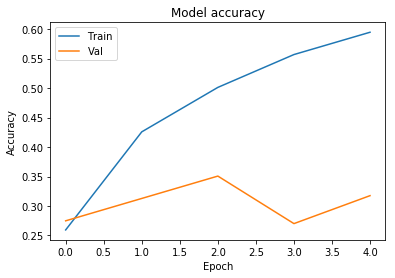

In [92]:
X_train_total = np.concatenate((X_train, new_data), axis=0)
y_train_total = np.concatenate((y_train_labels, y_train_labels), axis=0)

rnn = RNN(X_train_total, y_train_total, X_val, y_val_labels, X_test, y_test_labels)
rnn.train(RNN_architecture=LSTM, activation="softmax", \
              optimizer='adam', epochs=5, batch_size=64, dropout=0.5, units=500)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


rnn.plot()